# TGDS Model with Pretraining

In [1]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.pretrained_lstm_model as lstm

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [2]:
HYPER_PARAMS =  np.load('../../../models/TGDS/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_pretraining_epochs': 5,       # number of training epochs
    'n_training_epochs': 5,          # number of training epochs
    'n_features': 2,                 # number of input features
    'd_t': 0.25,                     # current integration factor
    'num_repeat': 1,                 # repetition factor for each training profile to create more auxiliary data
    'num_repeat_pretrain':10,
    'theory_model': 2228,            # the unique thevenin model ID for which the parameters have been computed
}

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Pretraining Data

In [3]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()
pretraining_sets = TRAINING_SETS['10A_all']

pretrain_data = []
for set in pretraining_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat_pretrain']
    pretrain_data += set_repeat
    
pretrain_data = np.array(pretrain_data)

# prepare pretraining data
X_pretrain, y_pretrain, scalers_pretrain = util.prepare_pretraining_input(HYPER_PARAMS, pretrain_data, 0, 4)

Input: (39500, 100, 2)  Output/Label: (39500, 1)


### Prepare Training/Validation/Test Data

In [4]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
# training_sets = TRAINING_SETS['10A_all'] + TRAINING_SETS['-10A_all'] + TRAINING_SETS['25A_all'] + TRAINING_SETS['-25A_all']
training_sets = TRAINING_SETS['10A_all']

train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]] 

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare training data
X_train, y_train, scalers_train = util.prepare_current_charge_input(HYPER_PARAMS, train_data, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_validation, y_validation, _ = util.prepare_current_charge_input(HYPER_PARAMS, validation_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_test, y_test, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profile, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (7900, 100, 2)  Output/Label: (7900, 1)
Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (1450, 100, 2)  Output/Label: (1450, 1)


### Initialize Model

In [5]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

Model: "Autoencoder_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10600     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 2)            424       
_________________________________________________________________
dense (Dense)                (None, 100, 1)            3         
Total params: 11,027
Trainable params: 11,027
Non-trainable params: 0
_________________________________________________________________
Model: "Pretrained_LSTM"
_________________________________________________________________
Layer (type)         

### Pretrain Model

Epoch 1/5
1235/1235 [==============================] - 173s 140ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0274
Epoch 2/5
1235/1235 [==============================] - 170s 138ms/step - loss: 8.5523e-04 - mse: 8.5523e-04 - mae: 0.0253
Epoch 3/5
1235/1235 [==============================] - 170s 138ms/step - loss: 8.3858e-04 - mse: 8.3858e-04 - mae: 0.0252
Epoch 4/5
1235/1235 [==============================] - 171s 138ms/step - loss: 8.2840e-04 - mse: 8.2840e-04 - mae: 0.0251
Epoch 5/5
1235/1235 [==============================] - 171s 139ms/step - loss: 8.2575e-04 - mse: 8.2575e-04 - mae: 0.0251
Pretraining time: 856.78s


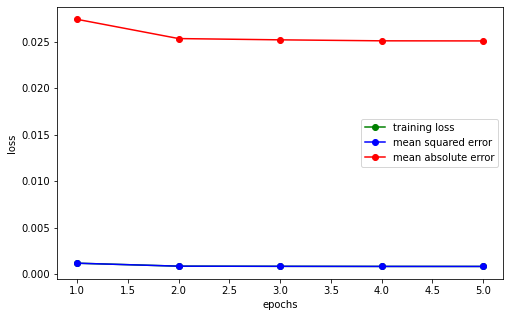

In [6]:
_, fig = lstm.pretrain(X_pretrain, y_pretrain, scalers_train)

# save model and hyperparameters
MODEL_ID = str(np.random.randint(10000))

# lstm.sequence_autoencoder.save('../../../models/TGDS/' + str(MODEL_ID))
# np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
# fig.savefig('../../../reports/figures/theory_guided_pretraining-' + str(MODEL_ID) + '-learning_curve.png')

### Train Model

Epoch 1/5
247/247 [==============================] - 56s 227ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0316
Epoch 2/5
247/247 [==============================] - 56s 227ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0301
Epoch 3/5
247/247 [==============================] - 56s 227ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0301
Epoch 4/5
247/247 [==============================] - 56s 228ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0299
Epoch 5/5
247/247 [==============================] - 56s 229ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0300
Training time: 282.322s


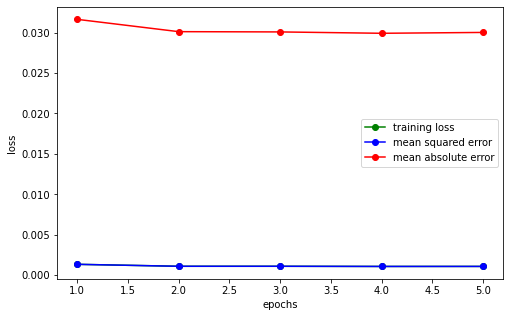

In [7]:
_, fig = lstm.train(X_train, y_train, scalers_train)

# save model and hyperparameters
MODEL_ID = str(np.random.randint(10000))

# lstm.model.save('../../../models/TGDS/' + str(MODEL_ID))
# np.save('../../../models/TGDS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
# fig.savefig('../../../reports/figures/theory_guided_pretraining-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A Run 080618']
247/247 [==============================] - 21s 87ms/step
Prediction time on Training Set:  21.507s
47/47 [==============================] - 4s 85ms/step
Prediction time on Validation Set:  4.104s
46/46 [==============================] - 4s 85ms/step
Prediction time on Test Set:  3.995s
###########################################################
            Training    Validation     Test
--------  ----------  ------------  -------
MSE (μV)    121.1         270.9     81.5
MAE (V)       0.0101        0.0162   0.0076
MaxE (V)      0.0248        0.0248   0.0144
###########################################################


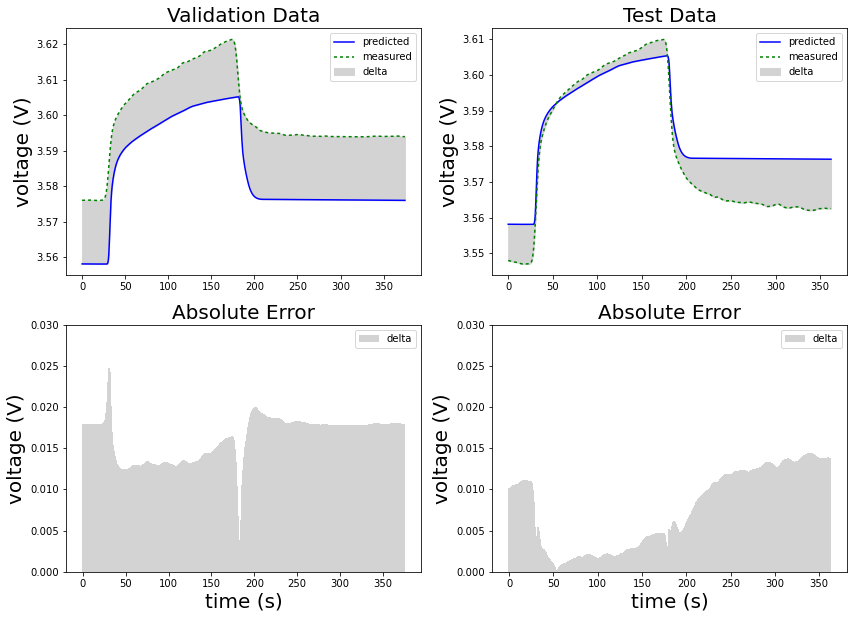

In [8]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, _, _, fig = lstm.test(X_train, y_train, X_validation, y_validation, X_test, y_test, scalers_train)

# save plots and predicted sequences
# np.save('../../../models/TGDS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
# fig.savefig('../../../reports/figures/theory_guided_charge-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [9]:
TEST_SETS =  np.load('../../../models/TGDS/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

test_profiles_usecase_1 = TEST_SETS['Reproduction']
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

X_case_1, y_case_1, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profiles_usecase_1, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_2, y_case_2, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profiles_usecase_2, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])
X_case_3, y_case_3, _ = util.prepare_current_charge_input(HYPER_PARAMS, test_profiles_usecase_3, HYPER_PARAMS['stack'], HYPER_PARAMS['cell'])

Input: (1500, 100, 2)  Output/Label: (1500, 1)
Input: (3100, 100, 2)  Output/Label: (3100, 1)
Input: (1600, 100, 2)  Output/Label: (1600, 1)


### Test Model on Use Cases

Use Case 1: ['Profile 10A']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']
247/247 [==============================] - 22s 88ms/step
Prediction time on Training Set:  21.878s
47/47 [==============================] - 4s 86ms/step
Prediction time on Use Case 1:  4.122s
97/97 [==============================] - 8s 86ms/step
Prediction time on Use Case 2:  8.476s
50/50 [==============================] - 4s 87ms/step
Prediction time on Use Case 3:  4.43s
##############################################################
            Training    Use Case 1    Use Case 2    Use Case 3
--------  ----------  ------------  ------------  ------------
MSE (μV)    121.1         270.9         183.7         106.3
MAE (V)       0.0101        0.0162        0.0097        0.0092
MaxE (V)      0.0248        0.0248        0.0325        0.0181
##############################################################


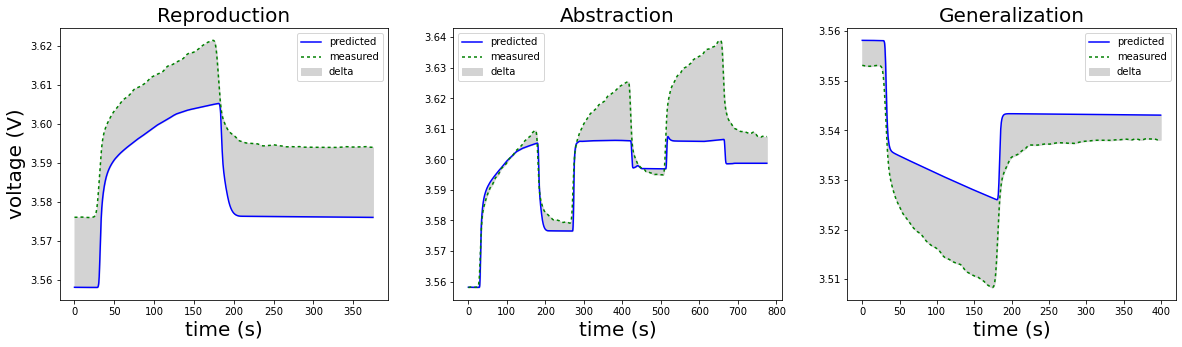

In [10]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

lstm.test_usecases(X_train, y_train, X_case_1, y_case_1, X_case_2, y_case_2, X_case_3, y_case_3, scalers_train)